<a href="https://colab.research.google.com/github/FrancLis/Multivariate-Time-Series-Forecasting/blob/main/1_Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fast_ml
!pip install talos
!pip install kats
!pip install scipy

In [12]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

import seaborn as sns
import pandas as pd
import talos as ta
from matplotlib import pyplot as plt
from fast_ml.model_development import train_valid_test_split
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D, Flatten

## 1. Data Acquisition

In [3]:
# Read Csv
file = r"/content/PG.csv"
df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')
plt.style.use('seaborn')

#### 1.1 Info Dataframe

In [4]:
df.shape[0]

13145

In [5]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,1.710938,1.722656,1.708984,1.718750,0.399508,832000
1970-01-05,1.718750,1.730469,1.708984,1.726563,0.401324,518400
1970-01-06,1.722656,1.722656,1.707031,1.718750,0.399508,480000
1970-01-07,1.722656,1.750000,1.722656,1.746094,0.405864,710400
1970-01-08,1.746094,1.773438,1.742188,1.765625,0.410404,531200


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,13145.000000,13145.000000,13145.000000,13145.000000,13145.000000,1.314500e+04
mean,36.142272,36.438890,35.866873,36.167073,26.801095,5.719207e+06
std,36.878137,37.155614,36.631969,36.899929,33.636763,5.268075e+06
min,1.273438,1.289063,1.253906,1.257813,0.295987,5.120000e+04
25%,3.304688,3.335938,3.281250,3.304688,1.119417,2.204800e+06
50%,21.000000,21.187500,20.812500,21.031250,11.034281,4.850600e+06
75%,62.540001,63.040001,62.119999,62.630001,42.619820,7.772900e+06
max,164.399994,165.350006,163.399994,164.210007,164.139999,1.372872e+08


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13145 entries, 1970-01-02 to 2022-02-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       13145 non-null  float64
 1   High       13145 non-null  float64
 2   Low        13145 non-null  float64
 3   Close      13145 non-null  float64
 4   Adj Close  13145 non-null  float64
 5   Volume     13145 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 718.9 KB


## 2. Data Visualization

##### 2.1 Time series visualization

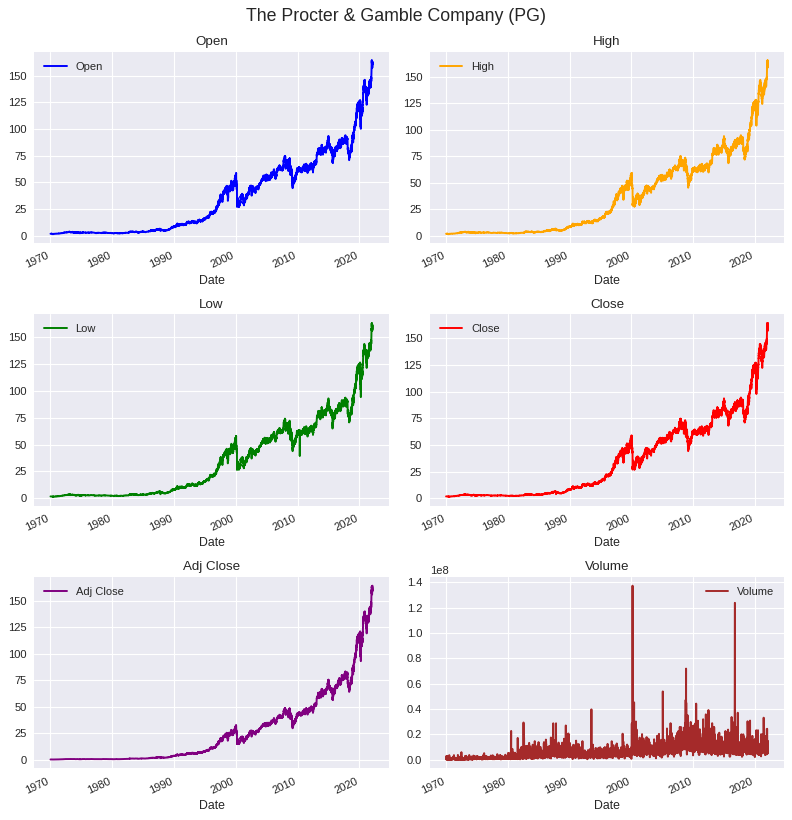

In [8]:
plt.style.use('seaborn')

titles = [
    "Open",
    "High",
    "Low",
    "Close",
    "Adj Close",
    "Volume",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
]


def show_raw_visualization(data):
    fig, axes = plt.subplots(
        nrows=3, ncols=2, figsize=(10, 10), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(titles)):
        c = colors[i % (len(colors))]
        t_data = data[titles[i]]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(titles[i]),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    fig.suptitle('The Procter & Gamble Company (PG)', fontsize=16, y=1.02)
    # plt.savefig('Timeseries_PG.png', dpi=1200)


show_raw_visualization(df)

##### 2.2 Correlation Heatmap

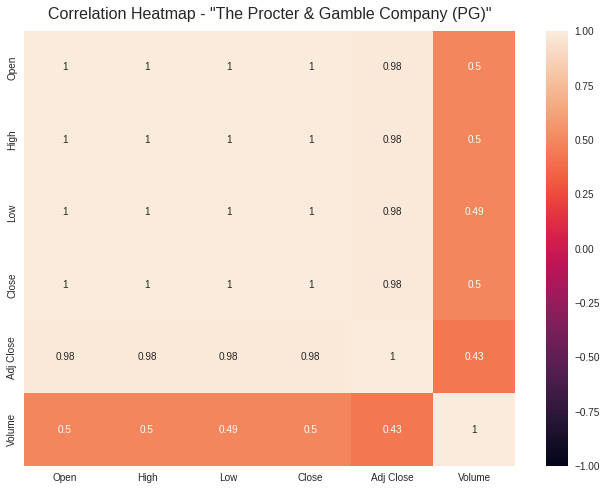

In [9]:
# Increase the size of the heatmap.
plt.figure(figsize=(11, 8))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title). Set
# the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the
# correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap - "The Procter & Gamble Company (PG)"', fontdict={'fontsize': 16}, pad=12)
# plt.savefig('Heatmap_PG.png', dpi=1200)
plt.show()

##### 2.3 Histogram

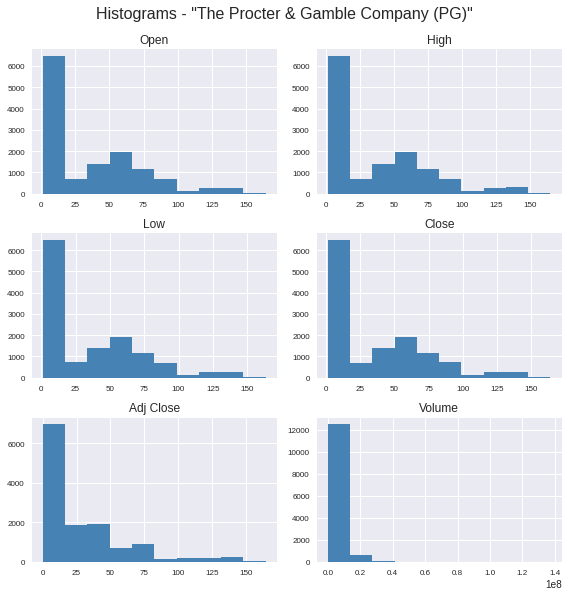

In [10]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(8, 8))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].hist(bins=10, ax=ax, color='steelblue', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=True)
        ax.set_title(var_name)
    plt.tight_layout()
    fig.suptitle('Histograms - "The Procter & Gamble Company (PG)"', fontsize=16, y=1.03)
    # plt.savefig('Histograms_PG.png', dpi=1200)
    plt.show()


draw_histograms(df, df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']], 3, 2)

##### 2.4 BoxPlot

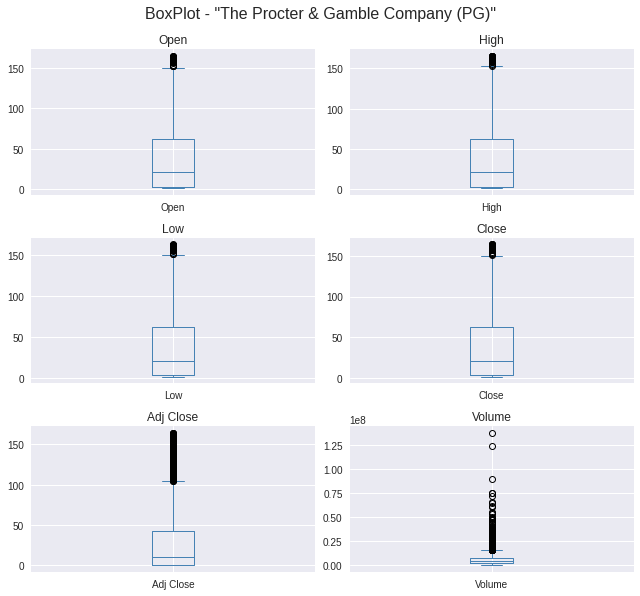

In [11]:
def draw_boxplot(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(9, 8))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].plot.box(ax=ax, color='steelblue', grid=True)
        ax.set_title(var_name)
    plt.tight_layout()
    fig.suptitle('BoxPlot - "The Procter & Gamble Company (PG)"', fontsize=16, y=1.03)
    # plt.savefig('BoxPlot_PG.png', format='png', dpi=1200)
    plt.show()


draw_boxplot(df, df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']], 3, 2)